In [1]:
#imports
import numpy as np
import numpy.random as rd
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1
    return 0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [3]:
en = 3
ch = 3
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
rate = np.array([8.,6.,4.])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
# P = row_normalize(np.random.rand(ch,ch)/2)
# E = np.random.rand(en,ch)/2
# rate = np.array([np.random.randint(1,10) for i in range(en)])
lr = 0.01
eps = .5
eps_min = 0.01
print(P)
print(E)
ub = np.sum(E*steady_state_prob(P),axis=1)
print(min(ub))

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
0.18360655737704915


In [4]:
tol = 0.25
ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(np.dot(ltemp.x,rate), np.sum(ltemp.x),ltemp.con, ltemp.success, np.dot(ltemp.x,ub))
print(ltemp.x)
org_lamda = ltemp.x

6.442622950819672 1.0 [0.] True 0.25
[0.22131148 0.77868852 0.        ]


In [5]:
print(en,ch,tol,np.dot(ltemp.x,rate),min(ub))
print(P)
print(E)
print(ltemp.x)

3 3 0.25 6.442622950819672 0.18360655737704915
[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[0.22131148 0.77868852 0.        ]


In [6]:
lamda = [np.ones(en)/en]
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
chnl = []; b = [] ; enc = []
emp_rate = [0]; emp_err = [0]
chnl.append(rd.randint(0,ch-1))
enc.append(rd.randint(0,en-1))
b.append(0)
step = 50
t = 0

In [7]:
T = 10000
sprob = steady_state_prob(p[-1])
r = rd.rand()
while t < T:
    if r < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(lamda[-1]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    if (t+1)%step == 0:
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if r < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(np.transpose([lamda[-1]])*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]])
        temp = np.copy(p[-1])
        lr = min(lr,1.0/float(t+1)) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        ub = np.sum(E*sprob,axis=1)
        ltemp = linprog(c = -1*rate, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        lamda.append(ltemp.x)
        r = rd.rand()
        emp_err.append(np.dot(ltemp.x,ub))
        emp_rate.append(np.dot(ltemp.x,rate))
        print(t,emp_rate[-1],ltemp.success,lr,)
    t+=1

49 6.331850407831848 True 0.01
99 6.33028613112085 True 0.01
149 6.332163961386243 True 0.006666666666666667
199 6.329928051411136 True 0.005
249 6.329252002729239 True 0.004
299 6.3292599919316705 True 0.0033333333333333335
349 6.329597660484911 True 0.002857142857142857
399 6.331036162582932 True 0.0025
449 6.3310700910155155 True 0.0022222222222222222
499 6.331572119327051 True 0.002
549 6.331559109036832 True 0.0018181818181818182
599 6.332128770148488 True 0.0016666666666666668
649 6.332147207188031 True 0.0015384615384615385
699 6.331922848159328 True 0.0014285714285714286
749 6.331926015040864 True 0.0013333333333333333
799 6.331720607722232 True 0.00125
849 6.332165714554281 True 0.001176470588235294
899 6.332168409260566 True 0.0011111111111111111
949 6.331634425002884 True 0.0010526315789473684
999 6.331636789987471 True 0.001
1049 6.331639063499251 True 0.0009523809523809524
1099 6.332060552840247 True 0.0009090909090909091
1149 6.332054221778447 True 0.0008695652173913044
1

In [8]:
# print(p[0])
print('estimated trans\n',p[-1])
print('real trans\n',P)
print('lamda\n',lamda[-1])
# print(sprob)
# print(model.transmat_)

estimated trans
 [[0.32900133 0.33271779 0.33828088]
 [0.32964228 0.33474376 0.33561396]
 [0.32885541 0.33351912 0.33762547]]
real trans
 [[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
lamda
 [0.16783536 0.83216464 0.        ]


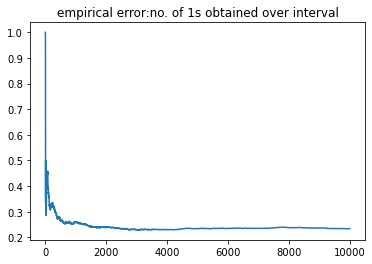

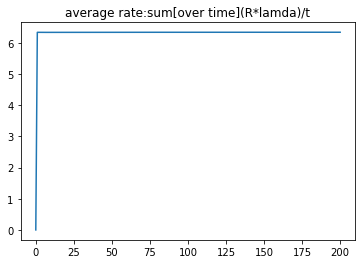

In [14]:
stat = 0
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(emp_rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [10]:
print(rate_plot[-1],error_plot[-1])

6.334284045315278 0.234


16.844488675163973


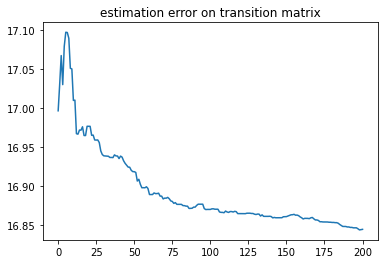

In [11]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(P-i))/s)*100)
print(err[-1])
plt.plot(err)
plt.title('estimation error on transition matrix')
plt.show()

6.3296


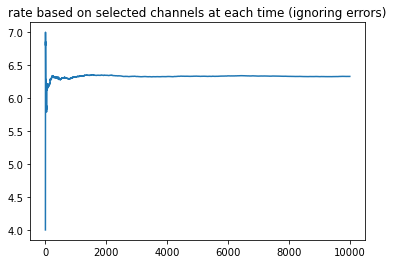

In [12]:
rate_plot = [0]
for i in range(1,len(enc)):
    rate_plot.append((rate_plot[i-1]*(i-1))+rate[enc[i]])
    rate_plot[i] =rate_plot[i]/i
print(rate_plot[-1])
plt.plot(rate_plot[stat:])
plt.title('rate based on selected channels at each time (ignoring errors)')
plt.show()

In [13]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(i)))/3)*100)
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('steady estimation error on transition matrix')
plt.show() 

[0.32916599 0.33366397 0.33717004]
[0.29508197 0.2704918  0.43442623]
6.978827452217994


KeyboardInterrupt: 

4.254777978126203


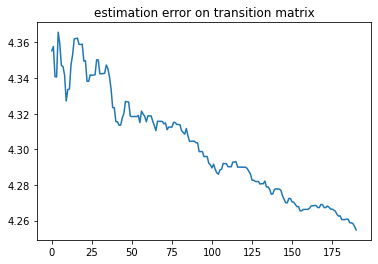

In [32]:
err = []; s = 3
for i in lamda:
    err.append(np.sqrt(np.sum(np.square(org_lamda-i))/s)*100)
print(err[-1])
plt.plot(err[10:])
plt.title('estimation error on transition matrix')
plt.show()s

In [31]:
lamda[-1], org_lamda

(array([0.1692013, 0.8307987, 0.       ]),
 array([0.22131148, 0.77868852, 0.        ]))

In [49]:
T = 10000
chnl = [0];enc = [1];b = [0]
t = 0
while t < T:
    enc.append(1)
    chnl.append(sample(P[chnl[-1]]))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    t+=1

In [50]:
# reference
model = hmm.MultinomialHMM(n_components=3, algorithm='viterbi', params='t', init_params='t',n_iter=100, tol=1.0e-2)
model.emissionprob_ = [[E[1][0],1.0-E[1][0]],[E[1][1],1.0-E[1][1]],[E[1][2],1.0-E[1][2]]]
model.startprob_ = np.ones(ch)/ch
model.fit([b])
# print(model.emissionprob_,model.startprob_)
print(model.transmat_,P)
s = np.shape(P)[0]*np.shape(P)[1]
print('Error',np.sqrt(np.sum(np.square(P-model.transmat_))/s)*100)

[[0.2790877  0.32806269 0.3928496 ]
 [0.27522697 0.32742    0.39735303]
 [0.27093667 0.32666191 0.40240143]] [[0.09294828 0.05048098 0.85657074]
 [0.20445218 0.39956535 0.39598246]
 [0.48021494 0.24803462 0.27175044]]
Error 21.18705092075961
